In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import random 

C:\Users\denni\AppData\Local\Temp\ipykernel_13120\1782386425.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:

class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text  
        else:
            response.raise_for_status()

# Example usage
if __name__ == "__main__":
    api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
    system_id = "105034"
    
    pv_output_api = PVOutputAPI(api_key, system_id)
    
    # Example: Get status with specific parameters
    response = pv_output_api.get_status(date="20230531", ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id="23471")
    print(response)

def parse_response_to_dataframe(response):
    # Split the response string into individual entries
    entries = response.split(';')
    
    # Extract the first 4 fields from each entry
    data = []
    for entry in entries:
        # Skip any empty strings
        fields = entry.split(',')[:5]
        data.append(fields)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

# Parse the response and convert it to a DataFrame
df = parse_response_to_dataframe(response)
print(df)



20230531,06:05,0,0.000,0,NaN,NaN,NaN,NaN,23.5,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:10,3,0.001,36,36,0.012,NaN,NaN,24.0,223.0,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:15,7,0.002,48,48,0.015,NaN,NaN,25.4,223.1,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:20,13,0.004,72,72,0.023,NaN,NaN,26.4,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:25,19,0.006,72,72,0.023,NaN,NaN,27.0,223.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:30,28,0.009,108,108,0.035,NaN,NaN,27.5,224.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:35,37,0.012,108,108,0.035,NaN,NaN,27.8,223.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:40,49,0.016,144,144,0.046,NaN,NaN,28.1,222.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:45,62,0.020,156,156,0.050,NaN,NaN,28.4,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:50,78,0.025,192,192,0.062,NaN,NaN,28.5,223.8,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:55,94,0.030,192,192,0.062,NaN,NaN,28.8,223.5,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:00,114,0.037,240,240,0.077,NaN,NaN,29.0,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:05,136,0.044,264,264,0.085,NaN

In [4]:
# Combine Date and Time into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Create a complete time range for the day at 5-minute intervals
full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')

# Create a complete DataFrame with zero values
full_day_df = pd.DataFrame(index=full_day)
full_day_df['Energy generation (kWh)'] = 0
full_day_df['Efficiency'] = 0.000
full_day_df['Power generation (W)'] = 0

# Merge the complete DataFrame with the existing data
merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))

# Fill missing values with zero
merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)

# Drop the duplicate columns
merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]

# Filter out rows that are not exact hour values
merged_df = merged_df[merged_df.index.minute == 0]


# Reset index to have DateTime as a column
merged_df.reset_index(inplace=True)


C:\Users\denni\AppData\Local\Temp\ipykernel_13120\1563371316.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')


In [5]:

values = merged_df['Energy generation (kWh)'].tolist()


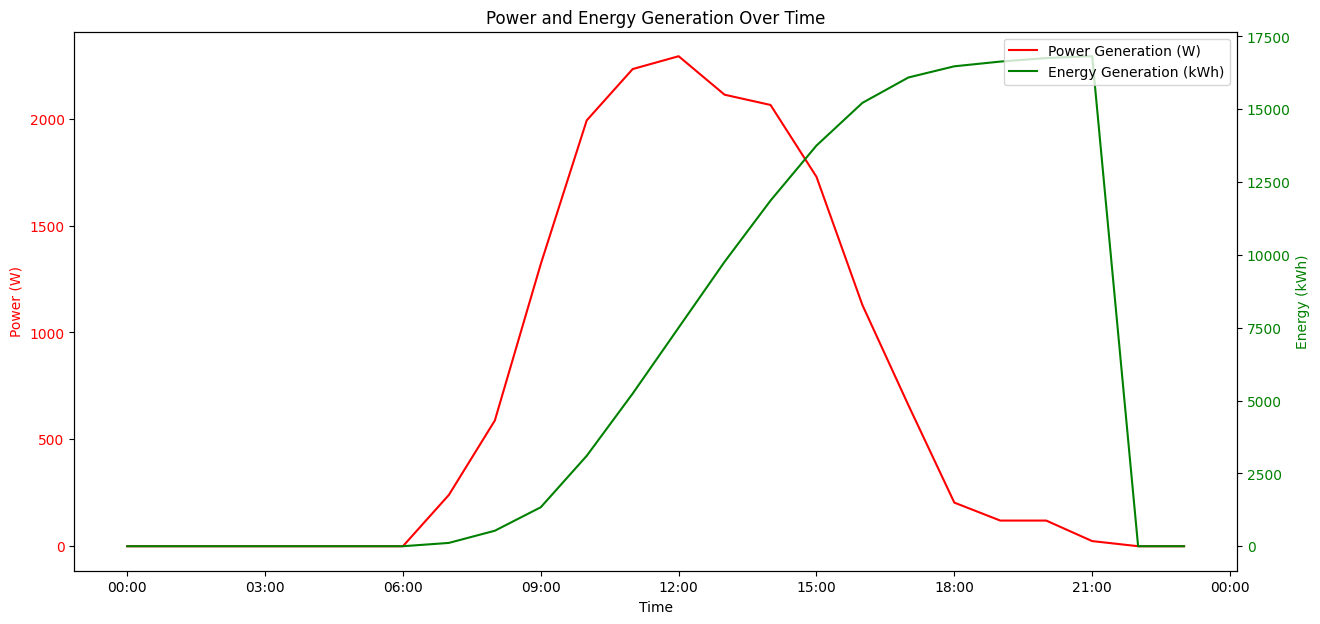

In [6]:
df = merged_df.copy()
# Convert 'index' column to datetime
df['index'] = pd.to_datetime(df['index'])

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Power Generation
ax1.plot(df['index'], df['Power generation (W)'], 'r-', label='Power Generation (W)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (W)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
#ax1.set_ylim(0, 5000)  # Scale y-axis to 5000W

# Create a secondary y-axis for Energy Generation
ax2 = ax1.twinx()
ax2.plot(df['index'], df['Energy generation (kWh)'], 'g-', label='Energy Generation (kWh)')
ax2.set_ylabel('Energy (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
#ax2.set_ylim(0, 20)  # Scale y-axis to 20 kWh

# Adding a legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Formatting the x-axis to show time only
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Adding a title
plt.title('Power and Energy Generation Over Time')

# Display the plot
plt.show()

In [12]:
from datetime import datetime, timedelta
import math

class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text
        else:
            response.raise_for_status()

def parse_response_to_dataframe(response):
    entries = response.split(';')
    data = []
    for entry in entries:
        fields = entry.split(',')[:5]
        data.append(fields)
    
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

def process_data_for_date(api, date,another_system_id):
    response = api.get_status(date=date, ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id=another_system_id)
    df = parse_response_to_dataframe(response)
    
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index('DateTime', inplace=True)
    
    full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
    full_day_df = pd.DataFrame(index=full_day)
    full_day_df['Energy generation (kWh)'] = 0
    full_day_df['Efficiency'] = 0.000
    full_day_df['Power generation (W)'] = 0
    
    merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
    
    merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
    merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
    merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)
    
    merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]
    merged_df = merged_df[merged_df.index.minute == 0]
    merged_df.reset_index(inplace=True)
    
    return merged_df

api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
system_id = "105034"
another_system_id = "77899"
pv_output_api = PVOutputAPI(api_key, system_id)

# Generate 10 random start dates
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 21)
random_dates = [start_date + timedelta(days=random.randint(0, (end_date - start_date).days)) for _ in range(10)]

all_data = []

# Collect data for each randomly selected start date and the subsequent 9 days
for start in random_dates:
    for offset in range(10):
        current_date = start + timedelta(days=offset)
        date_str = current_date.strftime("%Y%m%d")
        try:
            daily_data = process_data_for_date(pv_output_api, date_str,another_system_id)
            values = daily_data['Energy generation (kWh)'].tolist()
            # Replace NaN values with 0 in the values list
            values = [0 if math.isnan(int(x)) else int(x) for x in values]
            
            all_data.append({'Date': date_str, 'Values': values,'system_id':system_id})
        except Exception as e:
            print(f"Error processing date {date_str}: {e}")

final_df = pd.DataFrame(all_data)
print(final_df)
final_df.to_csv(f'measurement_data/energy_measurement_data_{another_system_id}.csv', index=False)



C:\Users\denni\AppData\Local\Temp\ipykernel_13120\895262393.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
C:\Users\denni\AppData\Local\Temp\ipykernel_13120\895262393.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
C:\Users\denni\AppData\Local\Temp\ipykernel_13120\895262393.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
C:\Users\denni\AppData\Local\Temp\ipykernel_13120\895262393.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  

Error processing date 20230526: 403 Client Error: Forbidden for url: https://pvoutput.org/service/r2/getstatus.jsp?d=20230526&h=1&asc=1&limit=500&from=00%3A00&to=23%3A55&ext=1&sid1=77899
Error processing date 20230527: 403 Client Error: Forbidden for url: https://pvoutput.org/service/r2/getstatus.jsp?d=20230527&h=1&asc=1&limit=500&from=00%3A00&to=23%3A55&ext=1&sid1=77899
Error processing date 20230528: 403 Client Error: Forbidden for url: https://pvoutput.org/service/r2/getstatus.jsp?d=20230528&h=1&asc=1&limit=500&from=00%3A00&to=23%3A55&ext=1&sid1=77899
Error processing date 20230529: 403 Client Error: Forbidden for url: https://pvoutput.org/service/r2/getstatus.jsp?d=20230529&h=1&asc=1&limit=500&from=00%3A00&to=23%3A55&ext=1&sid1=77899
Error processing date 20230530: 403 Client Error: Forbidden for url: https://pvoutput.org/service/r2/getstatus.jsp?d=20230530&h=1&asc=1&limit=500&from=00%3A00&to=23%3A55&ext=1&sid1=77899
Error processing date 20230531: 403 Client Error: Forbidden for u

In [13]:
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import numpy as np
import ast


# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to fit Gaussian to daily data
def fit_gaussian_to_daily_data(hourly_data):
    x_numeric = np.arange(len(hourly_data))
    try:
        # Initial guesses: amplitude, center, and width
        p0 = [max(hourly_data), np.argmax(hourly_data), 10]
        popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
        return popt
    except Exception as e:
        print(f"Error in Gaussian fit: {e}")
        return None

# Convert all elements in the list to integers
def convert_to_integers(data_list):
    return [int(x) if isinstance(x, str) else x for x in data_list]


# Load energy data from CSV
def load_and_process_data(filename):
    df = pd.read_csv(filename)
    results = []
    df_solar_panels = pd.read_csv('solarpanels.csv',sep=';')

    #print(df_system_id['sid'])
    panel_details = df_solar_panels[df_solar_panels['sid'] == int(another_system_id)]
    
    #print(panel_details['orientation']) #.iloc[0]
    print(panel_details)

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        try:
            # Safely convert string representation of list back to list
            energy_data = ast.literal_eval(row['Values'])

            # Convert all elements to integers
            energy_data = convert_to_integers(energy_data)

            #print(energy_data,type(energy_data[15]))
            popt = fit_gaussian_to_daily_data(energy_data)
            if popt is not None:
                # Generate dense x values for plotting or further analysis
                x_dense = np.linspace(0, 23, 500)
                gaussian_curve = gaussian(x_dense, *popt)
                area_gaussian = trapezoid(gaussian_curve, dx=x_dense[1] - x_dense[0])
                area_original = trapezoid(energy_data, dx=1)
                delta_auc = area_original / area_gaussian if area_gaussian != 0 else None
                results.append({
                    'Date': row['Date'],
                    'system_id':another_system_id,
                    'Orientation': panel_details['orientation'].values[0],
                    'Tilt': panel_details['tilt'].values[0],
                    'Panel Type': panel_details['type_panel'].values[0],
                    'Gaussian Parameters': popt,
                    'Delta AUC': delta_auc,
                    'energy_data': energy_data/ (panel_details['npanels'].values[0] * (panel_details['width'].values[0] /1000 )* (panel_details['height'].values[0]/1000)),
                })
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    return pd.DataFrame(results)

#print(system_id)
#solarpanels = pd.read_csv('solarpanels.csv',sep=';')
#solarpanels.head()
#solarpanels = solarpanels[solarpanels['sid'] == int(another_system_id)]
#print(solarpanels)
#Assuming the CSV file is in the current directory
filename = f'measurement_data/energy_measurement_data_{another_system_id}.csv'
fitted_results = load_and_process_data(filename)
fitted_results.to_csv(f'measurement_data/fitted_gaussian_results_{another_system_id}.csv', index=False)
fitted_results.head()



          name    sid  orientation  tilt inverter brand  ninverters  npanels  \
2  bomengarage  77899          158    10   Enphase IQ7+           6        6   

  panel brand panel max power       type_panel  width  height  \
2   QCells G5            335W  monocrystalline   1722    1134   

                                        url  
2  https://qcells.com.au/product/q-maxx-g5/  


,Date,system_id,Orientation,Tilt,Panel Type,Gaussian Parameters,Delta AUC,energy_data
0,20230909,77899,158,10,monocrystalline,"[11319.70231577883, 20.34518303480181, 4.58103...",0.975193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.389..."
1,20230910,77899,158,10,monocrystalline,"[10390.29298880236, 20.323477344437524, 4.5754...",0.973730,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.133..."
2,20230911,77899,158,10,monocrystalline,"[9534.067444778522, 20.118369914694888, 4.5891...",0.969911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.048..."
3,20230912,77899,158,10,monocrystalline,"[9566.50166391795, 19.974686673322925, 4.69017...",0.968565,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,20230913,77899,158,10,monocrystalline,"[6045.699534153299, 20.500567065272996, 4.8951...",0.976119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.792..."


In [14]:
import os 
directory = 'measurement_data/'

excel_files = [f for f in os.listdir(directory) if f.endswith('.csv') and f.startswith('fitted_gaussian_results_')]

print(excel_files)

dfs = []

# Loop through the list of files
for file in excel_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)  # Correct function to read CSV files
    dfs.append(df)

# Concatenate all dataframes
final_df = pd.concat(dfs, ignore_index=True)

filtered_df = final_df[final_df['Delta AUC'] <= 2]

final_output_path = 'measurement_data/final_measurement_data.csv'
filtered_df.to_csv(final_output_path, index=False)

['fitted_gaussian_results_13000.csv', 'fitted_gaussian_results_77899.csv']


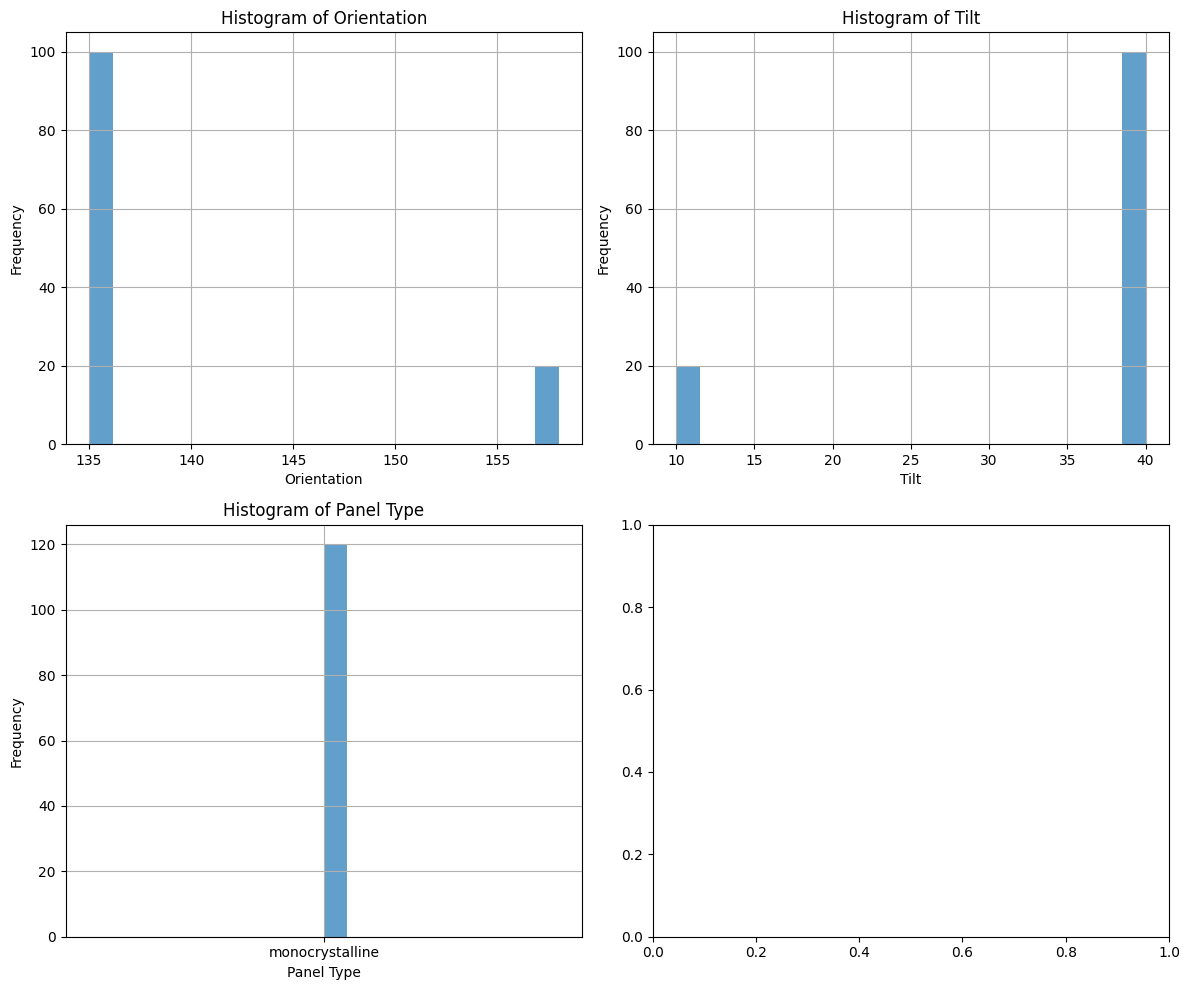

0.9676887057854998


In [15]:
hist_columns = ['Orientation', 'Tilt', 'Panel Type',]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten() 

for i, col in enumerate(hist_columns):
    if col in filtered_df.columns:
        filtered_df[col].hist(ax=axes[i], bins=20, alpha=0.7)
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].text(0.5, 0.5, f'{col} not found in DataFrame', fontsize=12, ha='center')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print(filtered_df['Delta AUC'].mean())

In [18]:
# Load the CSV files into DataFrames
df_solar = pd.read_csv('measurement_data/final_measurement_data.csv')
df_weather = pd.read_csv('measurement_data/historicalweather2023.csv')

# Convert date formats
# Assuming the date in df_solar is an integer or string without separators
df_solar['date'] = pd.to_datetime(df_solar['Date'].astype(str), format='%Y%m%d')

# Ensure the weather DataFrame date is in datetime format
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d')

# Merge the DataFrames on the date column
merged_df = pd.merge(df_solar, df_weather, on='date', how='left')

merged_df = merged_df.drop(['date'], axis=1)

new_column_names = {
    'Date': 'day',
    'Orientation': 'azimuth',
    'Tilt': 'tilt',
    'Panel Type': 'module_type',
    'Gaussian Parameters': 'gaussian_params',
    'Delta AUC': 'delta_auc',  
    'energy_data': 'energy_data',
    'temperature_sequence': 'temperature_sequence',
    'wind_speed_sequence': 'wind_speed_sequence',
    'dni_sequence': 'dni_sequence',
    'dhi_sequence': 'dhi_sequence',
    'global_irradiance_sequence': 'global_irradiance_sequence'
}

df_renamed = merged_df.rename(columns=new_column_names)

# Define the new order of the columns, placing 'delta_auc' last
new_order = [
    'day',
    'system_id',
    'delta_auc',
    'module_type',
    'tilt',
    'azimuth',
    'gaussian_params',
    'energy_data',
    'temperature_sequence',
    'wind_speed_sequence',
    'dni_sequence',
    'dhi_sequence',
    'global_irradiance_sequence',
]

# Reorder the columns
df_final = df_renamed[new_order]


# Save the merged DataFrame to a new CSV file
df_final.to_csv('merged_solar_weather_data.csv', index=False)